In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Preprocessing </h2>

<h3>Helper Functions</h3>

In [128]:
def create_feature_combinations(features): 
    combinations = []
    for i in features:
        for j in features:
            combo = sorted([i,j])
            if combo not in combinations:
                combinations.append(combo)
    return combinations

def check_higher_target_correlation(feature_a,feature_b,corr_target): #Check which feature is more correlated with the target
    feature_a_target_score = corr_target[feature_a]
    feature_b_target_score = corr_target[feature_b]
    if feature_a_target_score>feature_b_target_score:
        print("Since {} is more correlated with the target feature (NObeyesdad) than {}, we will keep this feature.\n".format(feature_a,feature_b))
        return feature_b
    else:
        print("Since {} is more correlated with the target feature (NObeyesdad) than {}, we will keep this feature.\n".format(feature_b,feature_a))
        return feature_a
    
def check_feature_correlation(corr_target,corr_features,threshold): # Goes through features and  remove any intercorrelation 
    final_features = corr_features.index.tolist()
    features = create_feature_combinations(corr_features.index)

    for combo in features:
        feature_a,feature_b = combo[0],combo[1]
        corr_score = corr_features[feature_a][feature_b] # check their correlation score

        if corr_score == 1: continue 
        if corr_score>threshold or corr_score < -1*threshold:
            print("{0} & {1} are highly correlated with a score of {2}. Therefore, we drop one of them".format(feature_a,feature_b,corr_score)) # check which feature is more correlated with target
            final_features.remove(check_higher_target_correlation(feature_a,feature_b,corr_target)) # remove feature from final feature list

    return final_features  


<h3>Correlation-based feature selection</h3>


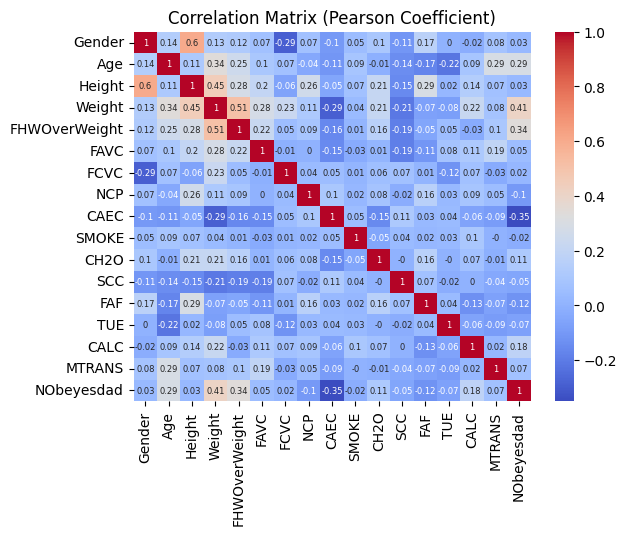

In [53]:
df = pd.read_csv("Data/DataEncoded.csv")
df_altered = df.rename(columns={"family_history_with_overweight":"FHWOverWeight"})
correlation = df_altered.corr().round(2)
sns.heatmap(correlation, annot=True, cmap = 'coolwarm', annot_kws={'size': 6})
plt.title("Correlation Matrix (Pearson Coefficient)")
plt.show()

We will consider the correlation to be significant when it is greater than 0.2 or less than -0.2.

In [129]:
threshold=0.2
cor_target = abs(correlation["NObeyesdad"])
relevant_features=pd.concat([cor_target[cor_target > threshold],cor_target[cor_target < -1*threshold]])
print("Relevant Features\n--------------------")
relevant_features


Relevant Features
--------------------


Age              0.29
Weight           0.41
FHWOverWeight    0.34
CAEC             0.35
NObeyesdad       1.00
Name: NObeyesdad, dtype: float64

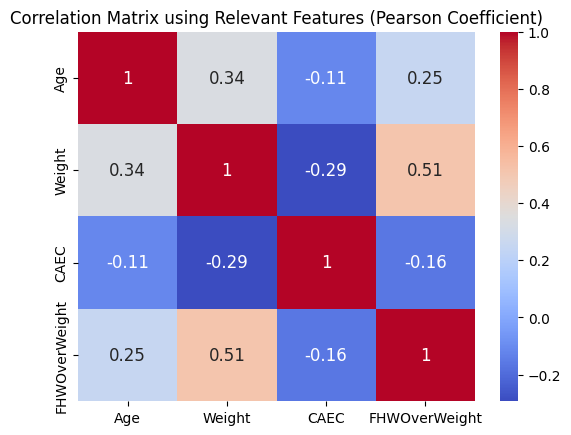

FHWOverWeight & Weight are highly correlated with a score of 0.5132816482213899. Therefore, we drop one of them
Since Weight is more correlated with the target feature (NObeyesdad) than FHWOverWeight, we will keep this feature.

Dataset after Correlation Based Feature Selection
--------------------------------------------------


,Age,Weight,CAEC,NObeyesdad
0,21.000000,64.000000,1.0,1
1,21.000000,56.000000,1.0,1
2,23.000000,77.000000,1.0,1
3,27.000000,87.000000,1.0,5
4,22.000000,89.800000,1.0,6
...,...,...,...,...
1934,20.976842,131.408528,1.0,4
1935,21.982942,133.742943,1.0,4
1936,22.524036,133.689352,1.0,4
1937,24.361936,133.346641,1.0,4


In [135]:
inter_correlation=df_altered[["Age","Weight","CAEC","FHWOverWeight"]].corr()
sns.heatmap(inter_correlation, annot=True, cmap = 'coolwarm', annot_kws={'size': 12})
plt.title("Correlation Matrix using Relevant Features (Pearson Coefficient)")
plt.show()

correlation_based_feature_selection = check_feature_correlation(cor_target,inter_correlation,0.5)

print("Dataset after Correlation Based Feature Selection\n--------------------------------------------------")
df_correlation_based = df[["Age","Weight","CAEC","NObeyesdad"]]
#df_correlation_based.to_csv("Data/Data_CorrelationBasedFeatureSelection.csv")
df_correlation_based

<h2> After Model Selection </h2>

<h3>Entropy / Information Gain</h3>

<h3>Gini Index</h3>

<h3>Backward Elimination</h3>